In [1]:
import numpy as np
import matplotlib.pyplot as  plt

import imageio
import copy

### **Функции преобразования из rgb в hsv и обратно**

In [2]:
def rgb2hsv_pix(pixel):
    """
    Convert type of a single pixel from rgb to hsv
    
    :pixel: - list with 3 numbers (int or float)
    :rtype: - list with 3 numbers (floats) [h, s, v]
    """
    assert len(pixel) == 3, ('list with length == 3 is expected')
    pixel = np.array(pixel)
    
    if pixel.dtype == 'uint8':
        r = 0 if pixel[0] < 0 else 255 if pixel[0] > 255 else pixel[0]/255
        g = 0 if pixel[1] < 0 else 255 if pixel[1] > 255 else pixel[1]/255
        b = 0 if pixel[2] < 0 else 255 if pixel[2] > 255 else pixel[2]/255
    else:
        r = 0 if pixel[0] < 0 else 1 if pixel[0] > 1 else pixel[0]
        g = 0 if pixel[1] < 0 else 1 if pixel[1] > 1 else pixel[1]
        b = 0 if pixel[2] < 0 else 1 if pixel[2] > 1 else pixel[2]
    
        
    cmax, cmin = max(r, g, b), min(r, g, b)
    diff = cmax - cmin
    
    # Hue calculation
    if diff == 0:
        h = 0
    elif cmax == r:
        h = (60 * ((g - b) / diff) + 360) % 360
    elif cmax == g:
        h = (60 * ((b - r) / diff) + 120) % 360
    elif cmax == b:
        h = (60 * ((r - g) / diff) + 240) % 360
        
    # Saturation calculation
    s = (diff / cmax) * 100 if (cmax != 0) else 0
    
    # Value calculation
    v = cmax * 100
    
    return [h, s, v]

In [3]:
def hsv2rgb_pix(pixel):
    """
    Convert type of a single pixel from hsv to rgb
    
    :pixel: - list with 3 numbers (floats)
    :rtype: - list with 3 numbers (floats) [h, s, v]
    """
    assert len(pixel) == 3, ('list with length == 3 is expected')
    
    pixel[1] = pixel[1] / 100 
    pixel[2] = pixel[2] / 100
    
    h = pixel[0] % 360
    s = 0 if pixel[1] < 0 else 1 if pixel[1] > 1 else pixel[1]
    v = 0 if pixel[2] < 0 else 1 if pixel[2] > 1 else pixel[2]
        
    c = v * s
    x = c * (1 - abs((h / 60) % 2 - 1))
    m = v - c
    
    if 0 <= h < 60:
        r = (c + m) * 255
        g = (x + m) * 255
        b = m * 255
    
    elif 60 <= h < 120:
        r = (x + m) * 255
        g = (c + m) * 255
        b = m * 255
    
    elif 120 <= h < 180:
        r = m * 255
        g = (c + m) * 255
        b = (x + m) * 255
        
    elif 180 <= h < 240:
        r = m * 255
        g = (x + m) * 255
        b = (c + m) * 255
    
    elif 240 <= h < 300:
        r = (x + m) * 255
        g = m * 255
        b = (c + m) * 255
    
    else:
        r = (c + m) * 255
        g = m * 255
        b = (x + m) * 255
    return [r, g, b]

In [4]:
rgb2hsv_pix([255, 255, 255])

[0, 0.0, 100]

In [5]:
hsv2rgb_pix([0, 0.0, 100.0])

[255.0, 255.0, 255.0]

In [6]:
def rgb2hsv_img(img):
    """
    Convert colormap of inputed image from rgb to hsv
    
    :img: - image in rgb format
    :rtype: - image in hsv format
    """
    img_hsv = np.empty(img.shape, dtype='float')
    
    for row in range(img_hsv.shape[0]):
        for col in range(img_hsv.shape[1]):
            img_hsv[row, col] = rgb2hsv_pix(img[row, col])
    return img_hsv

In [7]:
def hsv2rgb_img(img):
    """
    Convert colormap of inputed image from hsv to rgb
    
    :img: - image in hsv format
    :rtype: - image in rgb format
    """
    img_rgb = np.empty(img.shape, dtype='float')
    
    for row in range(img_rgb.shape[0]):
        for col in range(img_rgb.shape[1]):
            img_rgb[row, col] = hsv2rgb_pix(img[row, col])
    return img_rgb.astype('uint8')

In [8]:
img = imageio.imread('Cat.jpg')

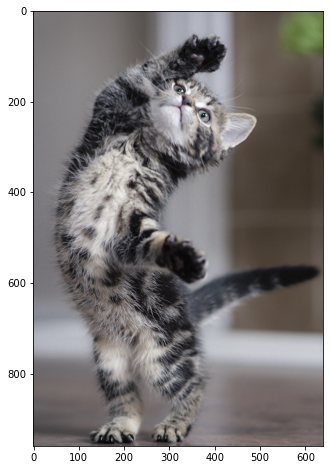

In [9]:
plt.figure(figsize=(8, 8))
plt.imshow(img)

Для демонстрации работы понизим яркость изображения на 20%

In [10]:
img_hsv = rgb2hsv_img(img)

In [11]:
img_hsv[:, :, 2] -= 20
img_rgb_changed = hsv2rgb_img(img_hsv)

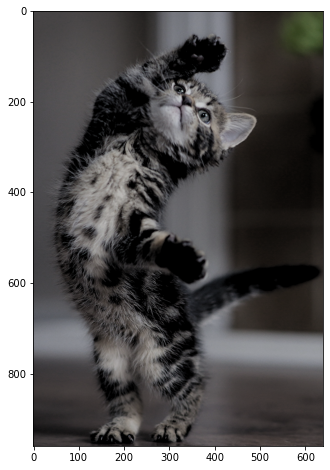

In [12]:
plt.figure(figsize=(8, 8))
plt.imshow(img_rgb_changed)

### **Функция свертки произвольным фильтром**

In [19]:
def convolution(img, w):
    """
    Apply filter w to the image and return new image
    
    :img: - image
    :w: - convolition filter
    
    :rtype: img-like array
    """
    if len(img.shape) == 3:
        assert len(img[0, 0]) == len(w[0, 0]), 'Filter must have same depth as an image colormap!'
    w = np.array(w)
    
    if len(img.shape) == 3:
        out_img = np.empty((img.shape[0] - w.shape[0] + 1,
                            img.shape[1] - w.shape[1] + 1,
                            img.shape[2]), 
                           dtype='float32')
    else:
        out_img = np.empty((img.shape[0] - w.shape[0] + 1,
                            img.shape[1] - w.shape[1] + 1), 
                           dtype='float32')
        
    for row in range(out_img.shape[0]):
        for col in range(out_img.shape[1]):
            region = img[row: row+w.shape[0], 
                         col: col+w.shape[1]]
            
            if len(img.shape) == 3:
                for i in range(img.shape[2]):
                    out_img[row, col, i] = np.sum(np.multiply(region[:, :, i], w[:, :, i]))
            else:
                out_img[row, col] = np.sum(np.multiply(region, w))
            
            
    if img.dtype == 'uint8':
        out_img /= 255
    
    return out_img

In [14]:
img_gray = np.mean(img, axis=2)

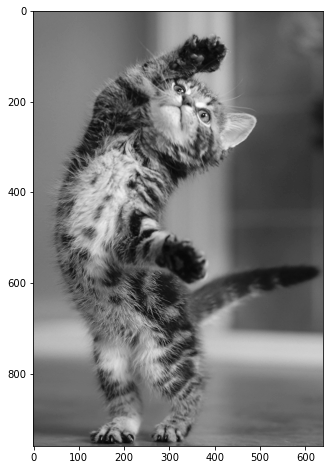

In [15]:
plt.figure(figsize=(8, 8))
plt.imshow(img_gray, cmap='gray')

In [16]:
win_size = (11, 11)
w = np.ones(win_size, dtype=np.float32)
w = w / np.sum(w)

In [20]:
img_conv = convolution(img_gray, w)

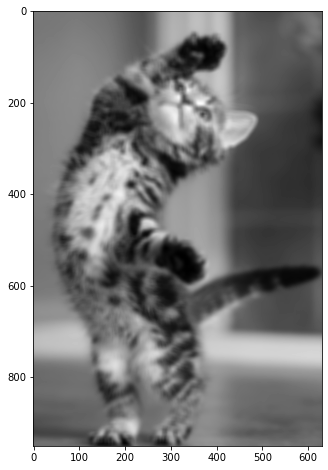

In [21]:
plt.figure(figsize=(8, 8))
plt.imshow(img_conv, cmap='gray')

In [22]:
win_size = (11, 11, 3)
w3 = np.ones(win_size, dtype=np.float32)
for i in range(3):
    w3[:, :, i] = w3[:, :, i] / np.sum(w3[:, :, i])

In [23]:
conv_col_img = convolution(img, w3)

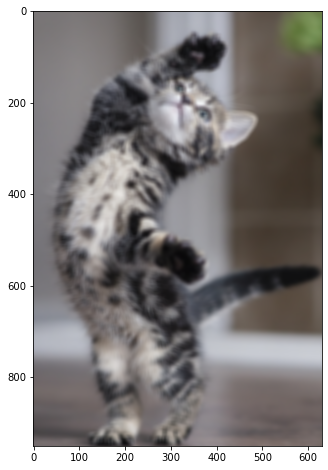

In [24]:
plt.figure(figsize=(8, 8))
plt.imshow(conv_col_img)